In [ ]:
from google.colab import files

uploaded = files.upload()  # Te abrirá un cuadro para seleccionar el CSV

import pandas as pd
titanic = pd.read_csv("Titanic-Dataset.csv")
print(titanic.head())

Saving Titanic-Dataset.csv to Titanic-Dataset (1).csv
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Primeras 5 filas:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500  

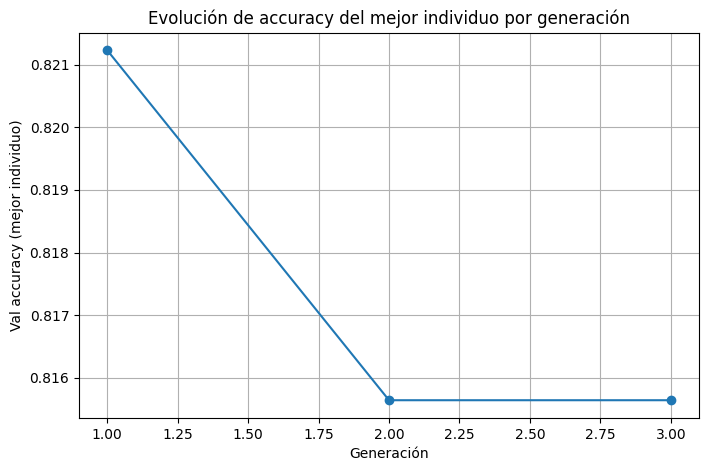

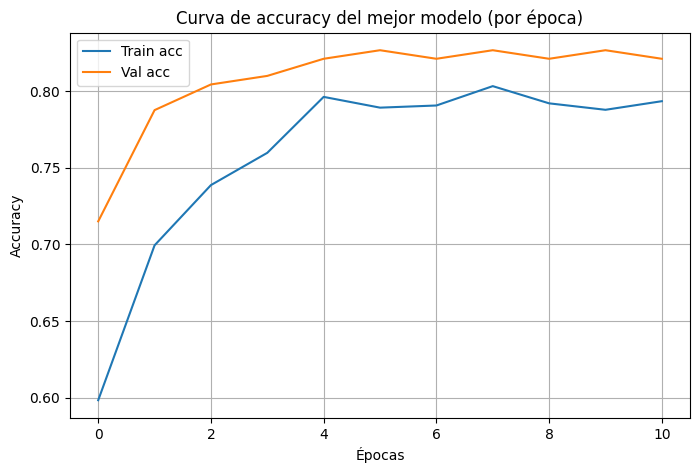

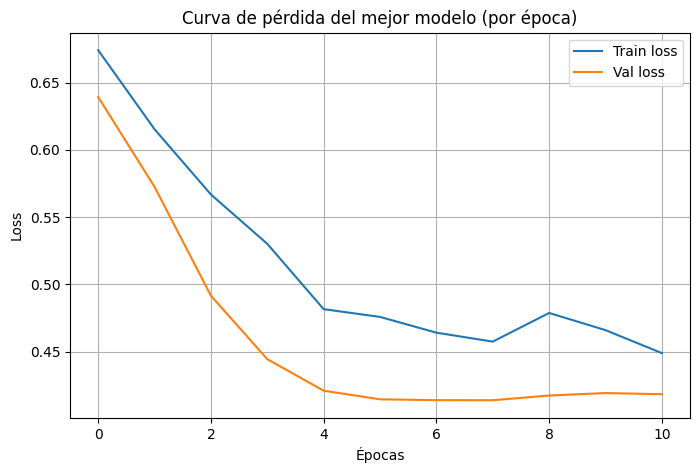

In [ ]:
# Código corregido y listo para Colab
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import random
import matplotlib.pyplot as plt
import gc
import os

# ------------------------
# Semillas para reproducibilidad
# ------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ------------------------
# 1) Cargar dataset (ajusta la ruta si es necesario)
# ------------------------
titanic = pd.read_csv("/content/drive/MyDrive/Ingeniería de Sistemas/Noveno Semestre/APRENDIZAJE DE MAQUINA/Actividad 02/Titanic-Dataset.csv")
print("Primeras 5 filas:")
print(titanic.head())

# ------------------------
# 2) Preprocesamiento
# ------------------------
y = titanic["Survived"]
X = titanic.drop(["Survived", "PassengerId", "Name", "Ticket", "Cabin"], axis=1)

# Codificar variables categóricas
for col in ["Sex", "Embarked"]:
    X[col] = X[col].fillna("Missing")
    X[col] = LabelEncoder().fit_transform(X[col])

# Rellenar valores faltantes numéricos
X["Age"] = X["Age"].fillna(X["Age"].median())
X["Fare"] = X["Fare"].fillna(X["Fare"].median())

# Normalizar
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Codificar salida a one-hot
y = tf.keras.utils.to_categorical(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

print("\nShapes:")
print("X shape:", X.shape)
print("X_train", X_train.shape, "X_test", X_test.shape)
print("y_train", y_train.shape, "y_test", y_test.shape)

# ------------------------
# 3) Funciones del AG y modelo
# ------------------------

def random_architecture(min_layers=1, max_layers=3, min_neurons=5, max_neurons=50):
    num_layers = np.random.randint(min_layers, max_layers + 1)
    return [int(np.random.randint(min_neurons, max_neurons)) for _ in range(num_layers)]

def build_model_from_arch(arch, input_dim, output_dim, dropout_rate=0.2):
    """Crea un modelo Keras dado un 'arch' (lista de neuronas por capa)."""
    tf.keras.backend.clear_session()  # limpia la sesión para liberar memoria
    model = Sequential()
    # Usar Input para evitar warnings
    model.add(tf.keras.Input(shape=(input_dim,)))
    # Añadir capas según arch
    for i, neurons in enumerate(arch):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def fitness_nn(arch, epochs=15, batch_size=32, early_stop=True):
    """
    Devuelve (history, score)
    - history: objeto History de Keras (para gráficas)
    - score: val_accuracy final (float)
    """
    try:
        model = build_model_from_arch(arch, input_dim=X.shape[1], output_dim=y.shape[1], dropout_rate=0.2)
        callbacks = []
        if early_stop:
            callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True))
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=callbacks
        )
        val_acc = history.history.get('val_accuracy')[-1]
        # Liberar memoria del modelo y forzar GC
        del model
        tf.keras.backend.clear_session()
        gc.collect()
        return history, float(val_acc)
    except Exception as e:
        print("Error al evaluar arquitectura", arch, "->", e)
        # En caso de error devolvemos un history vacío simulado y score 0
        dummy_hist = tf.keras.callbacks.History()  # objeto vacío, no perfecto pero sirve
        return dummy_hist, 0.0

def crossover(p1, p2):
    """Crossover robusto: elegimos un corte aleatorio válido."""
    min_len = min(len(p1), len(p2))
    if min_len == 0:
        return p1.copy() if len(p1) > 0 else p2.copy()
    cut = np.random.randint(1, min_len+1)  # entre 1 y min_len inclusive
    child = p1[:cut] + p2[cut:]
    return child

def mutate(arch, mutation_rate=0.3, min_neurons=5, max_neurons=50):
    new_arch = arch.copy()
    if np.random.rand() < mutation_rate:
        idx = np.random.randint(len(new_arch))
        new_arch[idx] = int(np.random.randint(min_neurons, max_neurons))
    return new_arch

# ------------------------
# 4) Ciclo evolutivo (parámetros)
# ------------------------
population_size = 6
generations = 3
epochs_per_eval = 15

# Inicializar
population = [random_architecture() for _ in range(population_size)]
print("\nPoblación inicial:", population)

best_arch = None
best_score = -1.0
best_history = None
evolution_history = []

for gen in range(1, generations+1):
    print(f"\n=== Generación {gen} ===")
    results = [fitness_nn(arch, epochs=epochs_per_eval) for arch in population]  # lista de (history,score)
    histories, scores = zip(*results)

    # Mostrar resultados y encontrar mejor de la generación
    for arch, score in zip(population, scores):
        print(f"Arquitectura: {arch} | Accuracy: {score:.4f}")

    gen_best_idx = int(np.argmax(scores))
    gen_best_score = float(scores[gen_best_idx])
    gen_best_arch = population[gen_best_idx]

    # Actualizar mejor global si aplica
    if gen_best_score > best_score:
        best_score = gen_best_score
        best_arch = gen_best_arch.copy()
        best_history = histories[gen_best_idx]

    evolution_history.append(gen_best_score)

    # Selección: tomar 2 mejores (elitismo simple)
    parents_idx = np.argsort(scores)[-2:]
    parents = [population[i] for i in parents_idx]
    print("Padres seleccionados:", parents)

    # Reproducción
    children = []
    for _ in range(population_size - len(parents)):
        p1, p2 = random.sample(parents, 2)
        child = crossover(p1, p2)
        child = mutate(child)
        children.append(child)

    # Nueva población
    population = parents + children

print("\n=== Mejor arquitectura encontrada ===")
print(f"Arquitectura: {best_arch} | Accuracy: {best_score:.4f}")

# ------------------------
# 5) Gráficas (comprueban que best_history existe)
# ------------------------
if best_history is None:
    print("Advertencia: no hay historial de entrenamiento del mejor modelo (best_history is None). No se pueden graficar curvas de entrenamiento.")
else:
    # 5.1 Evolución por generación
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(evolution_history)+1), evolution_history, marker='o')
    plt.title("Evolución de accuracy del mejor individuo por generación")
    plt.xlabel("Generación")
    plt.ylabel("Val accuracy (mejor individuo)")
    plt.grid(True)
    plt.savefig("evolucion_accuracy.png")
    plt.show()

    # 5.2 Curvas del mejor_history (accuracy)
    plt.figure(figsize=(8,5))
    plt.plot(best_history.history.get("accuracy", []), label="Train acc")
    plt.plot(best_history.history.get("val_accuracy", []), label="Val acc")
    plt.title("Curva de accuracy del mejor modelo (por época)")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig("curva_accuracy_mejor_modelo.png")
    plt.show()

    # 5.3 Pérdida (loss)
    plt.figure(figsize=(8,5))
    plt.plot(best_history.history.get("loss", []), label="Train loss")
    plt.plot(best_history.history.get("val_loss", []), label="Val loss")
    plt.title("Curva de pérdida del mejor modelo (por época)")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("curva_loss_mejor_modelo.png")
    plt.show()